In [1]:
%%capture
#!pip install wfdb
BASEPATH = '../'
import sys
sys.path.insert(0,'../py')
print(sys.path)
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from utils import reset_seed, plot_spectogram, plot_loss, load_data
from utils import integer_mapping, mapping_AAMI, MAP_AAMI, INT_MAP_DICT
from data_handling import DataHandling
from data_preprocessing import DataPreprocessing
from report import Reports
from models.model_with_one_mhb import MultiHeadAttentionClassifier 

reset_seed()

# Data

In [2]:
#Load Preprocessed data
x_train, y_train = load_data(file_path = '../data/DS1_features_train.dat')
#Load Preprocessed data
x_val, y_val = load_data(file_path = '../data/DS1_features_val.dat')
x_train.shape, len(y_train), x_val.shape, len(y_val)

File loaded: ../data/DS1_features_train.dat
File loaded: ../data/DS1_features_val.dat


((48664, 30, 40), 48664, (25500, 30, 40), 25500)

In [3]:
mean_train = np.mean(x_train)
std_train = np.std(x_train)

def stndr(arr,mean,std):
    X = arr.copy()
    X = (X - np.mean(X)) / np.std(X)
    return X

x_train = stndr(x_train,mean_train,std_train)
x_val = stndr(x_val,mean_train,std_train)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val  = train_test_split(features_train, y_train, 
                                                   test_size=0.30,stratify = y_train, 
                                                   random_state=142, shuffle=True)

In [4]:
dh = DataHandling()
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,19044,3948,3780,2008,2008,3682,2028,2025,2001,2050,2016,2070,0,0,2004
val,19043,1973,1890,8,8,1842,53,405,1,50,16,207,0,0,4


In [5]:
y_train = integer_mapping(y_train, INT_MAP_DICT)
y_val = integer_mapping(y_val, INT_MAP_DICT)

# Train

In [6]:
params = {
    'seq_len' : x_train.shape[-2],
    'd_model' : x_train.shape[-1],
    'num_heads' : 2,
    'num_classes' : 15,
    'drate' : 0.15,
    'batch_size' : 128,
    'epochs' : 60
}
print(params)

{'seq_len': 30, 'd_model': 40, 'num_heads': 2, 'num_classes': 15, 'drate': 0.15, 'batch_size': 128, 'epochs': 60}


In [7]:
model_classifier  = MultiHeadAttentionClassifier(
                                            seq_len=params['seq_len'],
                                            d_model = params['d_model'],
                                            num_heads = params['num_heads'],
                                            num_classes=params['num_classes'],
                                            drate=params['drate']
                                            )

In [10]:
batch_size = 2;seq_len = 3;d_model = 5;num_heads = 1;num_classes = 3
cls = MultiHeadAttentionClassifier(seq_len, d_model, num_heads, num_classes, drate=0.15)
x=tf.random.uniform((batch_size,seq_len,d_model))
cls.compile()
cls(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.35605016, 0.29659483, 0.347355  ],
       [0.35542873, 0.30340004, 0.3411712 ]], dtype=float32)>

In [11]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'
)

#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]


rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [12]:
%%time

model_history = model_classifier.fit(
              x=x_train,
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/60
279/279 [==============================] - 7s 19ms/step - loss: 0.3862 - accuracy: 0.8951 - val_loss: 0.5178 - val_accuracy: 0.8900

Epoch 00001: val_loss improved from inf to 0.51779, saving model to ../checkpoint/keras.EXP1


Epoch 2/60
279/279 [==============================] - 5s 18ms/step - loss: 0.2371 - accuracy: 0.9398 - val_loss: 0.2608 - val_accuracy: 0.9230

Epoch 00002: val_loss improved from 0.51779 to 0.26082, saving model to ../checkpoint/keras.EXP1


Epoch 3/60
279/279 [==============================] - 4s 15ms/step - loss: 0.1960 - accuracy: 0.9511 - val_loss: 0.4778 - val_accuracy: 0.8828

Epoch 00003: val_loss did not improve from 0.26082
Epoch 4/60
279/279 [==============================] - 5s 17ms/step - loss: 0.1727 - accuracy: 0.9572 - val_loss: 0.4908 - val_accuracy: 0.8901

Epoch 00004: val_loss did not improve from 0.26082
Epoch 5/60
279/279 [==============================] - 5s 17ms/step - loss: 0.1515 - accuracy: 0.9627 - val_loss: 0.4027 - val_accuracy: 0.8988

Epoch 00005: val_loss did not improve from 0.26082
Epoch 6/60
279/279 [==============================] - 5s 16ms/step - loss: 0.1398 - accuracy: 0.9659 - val_loss: 0.6038 - val_accuracy: 0.8863

Epoch 00006: val_loss did not improve from 0.26082
Epoch 7/60
279/279 [==============================] - 5s 18ms/step - loss: 0.1240 - accuracy: 0.9680 - val_loss: 0.5221 - val_accuracy: 0.8793

Epoch 00007: val_loss did not improve from 0.26082

Epoch 00007: ReduceLROnP

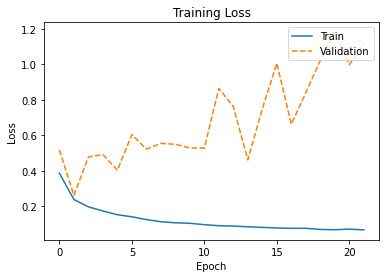

In [13]:
plot_loss(model_history)

In [14]:
import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)


In [15]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.26081758737564087, 1)

# Loading Model

In [16]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
loaded_model.name

'multi_head_attention_classifier_1'

In [17]:
#loaded_model.summary()

In [18]:
#Load Preprocessed Test Set
features_test, y_test = load_data(file_path = '../data/DS2_features.dat')
x_test = features_test
y_true = y_test.copy()
features_test.shape, len(y_test)

File loaded: ../data/DS2_features.dat


((49693, 30, 40), 49693)

In [25]:
x_test = stndr(x_test,mean_train,std_train)

In [26]:
%%time
y_pred_prob = loaded_model.predict(x_test)

CPU times: user 2.17 s, sys: 155 ms, total: 2.32 s
Wall time: 2.05 s


In [27]:
y_pred = integer_mapping(list(y_pred_prob.argmax(axis=-1)), INT_MAP_DICT, inverse=True)

In [28]:
dh = DataHandling()
rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
y_pred,33102,3480,2812,3,180,6270,2,740,1,0,1417,1684,2,0,0
y_true,36428,4124,3476,213,0,3219,1,1736,0,50,51,388,0,0,7


Precision or Positive Predictive Value (PPV):  TP/(TP+FP)

Sensitivity or Recall: TP/(TP+FN)

Specificity: TN/(TN+FP)

Accuracy (ACC): (TP+TN)/(TP+TN+FP+FN)

In [29]:
labels = [k for k,v in INT_MAP_DICT.items()]
report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
normalize = None
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
#report.metrics_table()


y_pred_AAMI = mapping_AAMI(y_pred, MAP_AAMI)
y_true_AAMI = mapping_AAMI(y_true, MAP_AAMI)
labels_AAMI = ['N','V','S','F','Q']
report = Reports(y_true=y_true_AAMI, y_pred=y_pred_AAMI, labels=labels_AAMI)
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
report.metrics_table()


/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mypc/anacond

              precision    recall  f1-score   support

           A     0.0027    0.0012    0.0016      1736
           E     0.0000    0.0000    0.0000         1
           F     0.0255    0.1108    0.0415       388
           J     0.0000    0.0000    0.0000        51
           L     0.0184    0.0155    0.0168      4124
           N     0.8500    0.7724    0.8093     36428
           Q     0.0000    0.0000    0.0000         7
           R     0.0836    0.0676    0.0747      3476
           S     0.0000    0.0000    0.0000         0
           V     0.4159    0.8102    0.5497      3219
           a     0.0000    0.0000    0.0000        50
           e     0.0000    0.0000    0.0000         0
           f     0.0000    0.0000    0.0000         0
           j     0.0000    0.0000    0.0000       213

    accuracy                         0.6256     49693
   macro avg     0.0997    0.1270    0.1067     49693
weighted avg     0.6577    0.6256    0.6359     49693

              precision  

,Class,(PPV)Precision,(Sensitivity)Recall,Specificity,Accuracy
0,F,2.55,11.08,96.67,96.00
1,N,94.09,84.17,57.10,81.20
2,Q,0.00,0.00,100.00,99.98
3,S,0.79,0.93,95.53,92.03
4,V,41.58,80.99,92.12,91.40


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred),accuracy_score(y_true_AAMI,y_pred_AAMI)

(0.6256213148733222, 0.803050731491357)

In [31]:
import matplotlib.pyplot as plt
#plt.style.use('/content/drive/MyDrive/ecARR/plotstyle.txt')

labels = [k for k,v in intMapDict.items()]
report = Reports(yTrue=y_true, yPred=y_pred, labels=labels)
normalize = 'true'
#report.plotConfusionMatrix(normalize=normalize, values_format='')
print(report.classificationReport())
report.metricsTable()


y_pred_AAMI = mappingAAMI(y_pred, MAP_AAMI)
y_true_AAMI = mappingAAMI(y_true, MAP_AAMI)
labels_AAMI = ['N','V','S','F','Q']
report = Reports(yTrue=y_true_AAMI, yPred=y_pred_AAMI, labels=labels_AAMI)
report.plotConfusionMatrix(normalize=normalize, values_format='.2%')
print(report.classificationReport())
report.metricsTable()


NameError: name 'intMapDict' is not defined

In [32]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True, formatter={'float_kind':'{:.2f}'.format})
cfm=confusion_matrix(y_true_AAMI, y_pred_AAMI, labels=sorted(labels_AAMI),normalize='true')*100
cfm
import pandas as pd
pd.DataFrame(cfm).round(2)

,0,1,2,3,4
0,11.08,10.05,0.00,25.26,53.61
1,3.53,84.17,0.00,4.60,7.70
2,14.29,0.00,0.00,0.00,85.71
3,0.00,96.68,0.00,0.93,2.40
4,2.45,16.27,0.03,0.25,80.99
